# SDOT Trees Data Exploration

## TODO

* Figure out the precise nature of the `x` and `y` coordinates.
* Figure out how  to superimpose the tree locations on top of a map of Seattle accurately.
* Create a new column to classify trees by their scientific name, but group very specific cultivars together.
* Identify any filterable data (e.g. there are trees with name "stump").
* Create a new column to indicate whether the tree species is indigenous.
* Learn about the pollenation radius of the indigenous trees. Is it different in urban areas?
* Identify areas which could use some more of any particular tree based on pollenation radii.
* Identify areas which have a lower indigeneous population.

Different trees are pollinated via different methods. These fall into two broad categories (and probably more), wind pollination and insect pollination. Wind pollination has a shorter range.

* Create a new column which indicates the type of pollination wind/insect/other for the tree based on its scientific name.
* Estimate the pollination range for trees based on their specific species information.

Some more

* Identify indigenous species which cannot be fertilized
  - Because there are no compatible trees
  - Because compatible trees are too far away

# Notes

* The `x` and `y` columns are likely measured in feet based on the State Plane Coordinate System (SPCS) for Washington North (EPSG:2285).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, TypedDict

In [13]:
df_raw = pd.read_csv('SDOT_Trees_CDL_20241119.csv', dtype={
    'CONDITION': 'string',
    'CONDITION_ASSESSMENT_DATE': 'string',
    'ASBUILTPLANNO': 'string',
})

# to squelch warnings about the data
df_raw['CONDITION'] = df_raw['CONDITION'].fillna('')
df_raw['CONDITION_ASSESSMENT_DATE'] = df_raw['CONDITION_ASSESSMENT_DATE'].fillna('')
df_raw['ASBUILTPLANNO'] = df_raw['ASBUILTPLANNO'].fillna('')

# to sanitize the data
df_raw['SCIENTIFIC_NAME'] = df_raw['SCIENTIFIC_NAME'].fillna('')
df_raw['COMMON_NAME'] = df_raw['COMMON_NAME'].fillna('')

In [14]:
print(df_raw.columns)

Index(['OBJECTID', 'COMPKEY', 'UNITID', 'UNITDESC', 'CONDITION',
       'CONDITION_ASSESSMENT_DATE', 'CURRENT_STATUS', 'PRIMARYDISTRICTCD',
       'SECONDARYDISTRICTCD', 'OVERRIDEYN', 'COMPTYPE', 'SEGKEY', 'UNITTYPE',
       'OWNERSHIP', 'CURRENT_STATUS_DATE', 'LAST_VERIFY_DATE', 'PLANTED_DATE',
       'BOTANICAL_NAME', 'SCIENTIFIC_NAME', 'HERITAGE', 'EXCEPTIONAL',
       'CODEREQ', 'GSI', 'GREEN_FACTOR', 'WIRES', 'CABLED',
       'CLEARANCE_PROBLEM', 'SPACETYPE', 'SITETYPE', 'GROWSPACE', 'DIAM',
       'CONDITION_RATING', 'FUNDING_SOURCE', 'WATER_THROUGH_YR1',
       'WATER_THROUGH_YR2', 'WATER_THROUGH_YR3', 'OWNERDIAM', 'EXPDATE',
       'COMMON_NAME', 'TREEHEIGHT', 'ASBUILTPLANNO', 'LANDSCAPEAREAASSOC',
       'COMMENTS', 'OVERRIDECOMMENT', 'SHAPE_LNG', 'SHAPE_LAT',
       'IRRIGATESYSYN', 'ASSETGROUPID', 'ASSETGROUPDESC', 'MODDATE',
       'TOTAL_RANK', 'TOTAL_COUNT', 'GENUS', 'UFMAINTMGMTUNIT', 'x', 'y'],
      dtype='object')


In [15]:
LOOKUP_MISSES = {}

def _clear_lookup_misses():
    global LOOKUP_MISSES
    LOOKUP_MISSES = {}

def _lookup_miss(kind: str, key: any):
    global LOOKUP_MISSES
    if kind in LOOKUP_MISSES:
        entries = LOOKUP_MISSES[kind]
    else:
        entries = LOOKUP_MISSES[kind] = set()
    if key not in entries:
        if len(entries) < 10:
            print(f'warning: lookup miss {kind=} {key=}')
        elif len(entries) == 10:
            print(f'warning: lookup miss {kind=} ...')
        entries.add(key)

def lookup_fertilization_direction(scientific_name_a: str, scientific_name_b: str) -> Tuple[bool, bool]:
    """returns a_to_b, b_to_a where a_to_b means a can fertilize b and b_to_a means b can fertilize a."""
    # assumed - a species can fertilize itself (TODO - probably not strictly true)
    if scientific_name_a == scientific_name_b:
        return True, True
    # TODO - get researching!
    _lookup_miss('fertilization_direction', (scientific_name_a, scientific_name_b))
    return False, False

def lookup_indigenous(row) -> bool:
    # TODO - handle the lat and lon values, but we're assuming a single biome for now in Seattle, WA
    scientific_name = row['SCIENTIFIC_NAME']
    if scientific_name == 'Cercidiphyllum japonicum':
        return False # https://gobotany.nativeplanttrust.org/species/cercidiphyllum/japonicum/
    # TODO - get researching!
    _lookup_miss('indigenous', (scientific_name, ))
    return True

class PollinationProfile(TypedDict):
    POLLINATION_TYPE: str # TODO one of INSECT, WIND, UNSPECIFIED
    POLLINATION_RANGE: float # meters - TODO validate what's x, y mean in the data?

# TODO for simplicity, one profile for insect and wind pollination is provided
INSECT_POLLINATOR_PROFILE: PollinationProfile = {
    'POLLINATION_TYPE': 'INSECT',
    'POLLINATION_RANGE': 200.0, # TODO reference
}
WIND_POLLINATOR_PROFILE: PollinationProfile = {
    'POLLINATION_TYPE': 'WIND',
    'POLLINATION_RANGE': 500.0, # TODO reference
}
UNSPECIFICED_POLLINATOR_PROFILE: PollinationProfile = {
    'POLLINATION_TYPE': 'UNSPECIFIED',
    'POLLINATION_RANGE': float('NaN'),
}

def lookup_pollination_profile(row) -> PollinationProfile:
    scientific_name = row['SCIENTIFIC_NAME']
    if scientific_name.lower().startswith('malus'): # TODO reference
        return INSECT_POLLINATOR_PROFILE
    # TODO - get researching!
    _lookup_miss('pollination_profile', (row['SCIENTIFIC_NAME'], ))
    return UNSPECIFICED_POLLINATOR_PROFILE

In [16]:
def insert_additional_information(df):
    def lookup_additional_information(row):
        result = {
            'INDIGENOUS': lookup_indigenous(row),
        }
        result.update(lookup_pollination_profile(row))
        return result

    _clear_lookup_misses()
    return df.join(df.apply(lookup_additional_information, axis=1).apply(pd.Series))

df = insert_additional_information(df_raw)

## Some Specific Trees

In [18]:
print(df[df['SCIENTIFIC_NAME'].str.startswith('Pseudotsuga')]['SCIENTIFIC_NAME'].value_counts())
print()
print(df[df['COMMON_NAME'].str.startswith('Bristle')]['SCIENTIFIC_NAME'].value_counts())
print()
#print(df[df['SCIENTIFIC_NAME'].str.startswith('Prunus')]['SCIENTIFIC_NAME'].value_counts())
#print()

#df[df['COMMON_NAME'].str.startswith('Bristle')]

SCIENTIFIC_NAME
Pseudotsuga menziesii    2435
Name: count, dtype: int64

SCIENTIFIC_NAME
Pinus aristata    27
Name: count, dtype: int64



## Where Are These Trees?

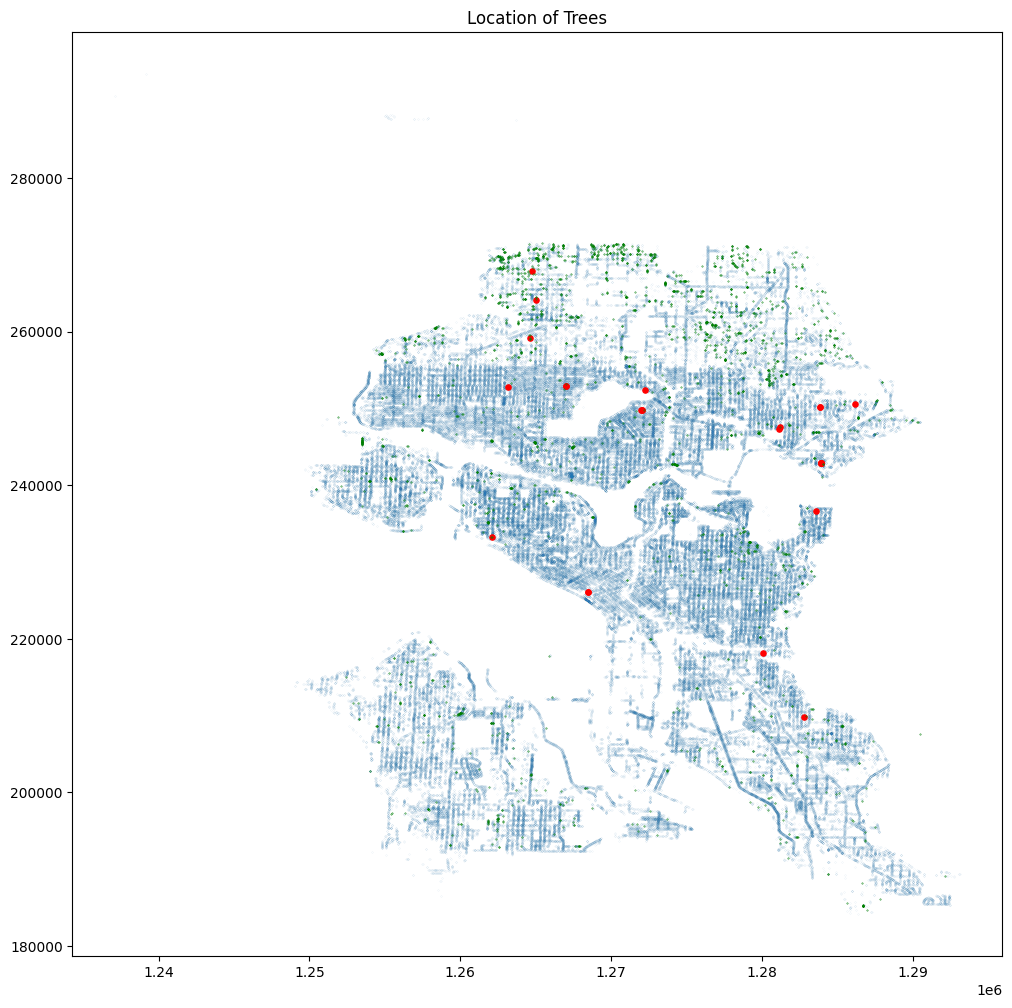

In [21]:
apples = df[df['SCIENTIFIC_NAME'].str.startswith('Malus')]
dfirs = df[df['SCIENTIFIC_NAME'].str.startswith('Pseudotsuga')]
bristles = df[df['SCIENTIFIC_NAME'] == 'Pinus aristata']
plt.figure(figsize=(12, 12))
plt.scatter(df['x'], df['y'], s=.001)
#plt.scatter(apples['x'], apples['y'], s=.1, color='red')
plt.scatter(bristles['x'], bristles['y'], s=14, color='red')
plt.scatter(dfirs['x'], dfirs['y'], s=.1, color='green')
plt.title('Location of Trees')
plt.show()

In [8]:
LOOKUP_MISSES

{'pollination_profile': {('',),
  ('+ Laburnocytidus adamii',),
  ('Abies amabilis',),
  ('Abies concolor',),
  ('Abies grandis',),
  ('Abies koreana',),
  ('Abies pinsapo',),
  ('Abies procera',),
  ('Abies sp.',),
  ('Abies veitchii',),
  ('Acacia pravissima',),
  ('Acer buergerianum',),
  ('Acer campestre',),
  ("Acer campestre 'Panacek'",),
  ("Acer campestre 'Queen Elizabet",),
  ('Acer capillipes',),
  ('Acer cappadocicum',),
  ('Acer circinatum',),
  ('Acer davidii',),
  ('Acer glabrum',),
  ('Acer griseum',),
  ('Acer japonicum',),
  ('Acer macrophyllum',),
  ('Acer maximowiczianum',),
  ("Acer miyabei 'JFS-KW3AMI'",),
  ("Acer miyabei 'Morton'",),
  ('Acer monspessulanum',),
  ('Acer negundo',),
  ('Acer palmatum',),
  ("Acer palmatum 'Bihou'",),
  ("Acer palmatum 'Osakazuki'",),
  ("Acer palmatum 'Tobiosho'",),
  ('Acer palmatum `Sango Kaku`',),
  ('Acer palmatum var. dissectum',),
  ('Acer palmatum var. dissectum f',),
  ('Acer pensylvanicum',),
  ('Acer platanoides',),
  ("